Как вы уже узнали из первой лекции, в роботехнике используются датчики. Датчики позволяют измерять различные величины, но делают они это неточно. Поэтому, с полученными от датчика данными перед использование необходимо что-то сделать, чтобы получить более точные значения измеряемой величины. Если измеряемая величина не изменяется со временем (достаточно быстро), то можно сделать много (в зависимости от разброса результатов измерения и необходимой точности) измерений и взять среднее значение. Но если измеряемая величина меняется со временем, нужно использовать какой-то фильтр. Для нас фильтр - это алгоритм, который принимает на входе данные с датчиков (как одного, так и нескольких) и выдаёт более точные значения измеряемой величины, чем полученные с датчиков измерения.

В этой лабораторной работе Вы познакомитесь с некоторыми фильтрами. В первой части рассмотрим некоторые простые фильтры.

Для начала импортируем NumPy и Matplotlib, с которые Вы уже встречали в нулевой лабораторной работе.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Далее мы будем рисовать много графиков. Очень много графиков. По умолчанию их размер достаточно маленький, поэтому с помощью следующей строки увеличим их размер.

In [2]:
plt.rcParams["figure.figsize"] = [12.8, 4.8]

Теперь сгенерируем данные и шум. Данные и шум могут быть различными в зависимости от датчика и его применения. В качестве данных для примера мы будем среднее из сумму двух синусоид. В качестве шума мы рассмотрим два случая: высокочастотный шум (сейчас) и низкочастотный шум (далее). Высокочастотный шум получим из генератора случайных чисел с нормальным распределением.

Построим график: данные (синяя линяя) и шум (оранжевая линяя):

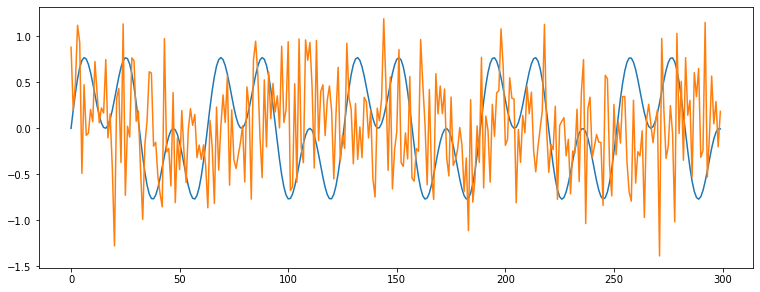

In [3]:
np.random.seed(0)
data = (np.sin(np.arange(300) * 0.1) + np.sin(np.arange(300) * 0.3)) * 0.5
noise = np.random.normal(0, 0.5, 300)
plt.plot(data)
plt.plot(noise)
plt.show()

Результаты измерения с датчиков вычисляем как сумму данных и шума. Суммировать данные и шум можно в различных пропорциях, чтобы получить неообходимое отношение сигнал (данные) / шум: https://en.wikipedia.org/wiki/Signal-to-noise_ratio

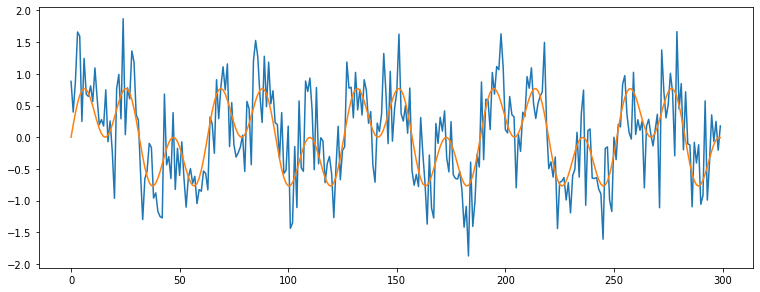

In [4]:
measurements = data + noise
plt.plot(measurements)
plt.plot(data)
plt.show()

Давайте рассмотрим пару фильтров. Начнём с простого - Low-pass filter. Подробно о нём можно почитать тут: https://en.wikipedia.org/wiki/Low-pass_filter

Если кратко, то текущее значение на выходе вычисляется из прошлого значения на выходе и текущего значения на входе этой формуле:
$$ y_i = y_{i-1} + \alpha \times (x_i - y_{i-1}), $$
где $x_i$ - входные данные, $y_i$ - выходные данные, $\alpha$ - параметр сглаживания.

Давайте попробуем его применить.


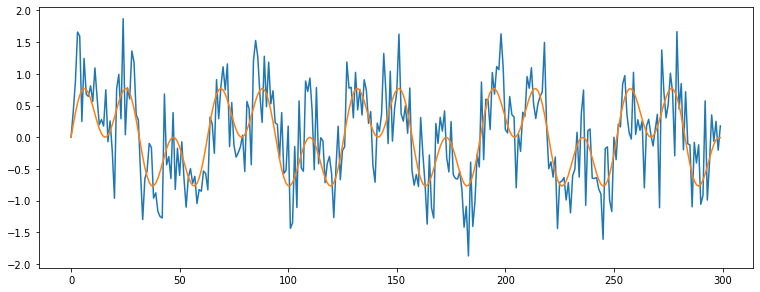

In [5]:
alpha = 1
filtered = np.zeros(measurements.shape[0])
for i in range(1, measurements.shape[0]):
  filtered[i] = filtered[i-1] + alpha * (measurements[i] - filtered[i-1])
plt.plot(filtered)
plt.plot(data)
plt.show()

Как видим, при $\alpha = 1$ ничего не изменяется (что очевидно из формулы выше). Давайте посмотрим, что будет при различных $\alpha$.

Чтобы численно оценить, насколько близки данные на выходе фильтра к изначальным данным (без шума), будем вычислять корень среднего квадрата отклонения.

Alpha: 0


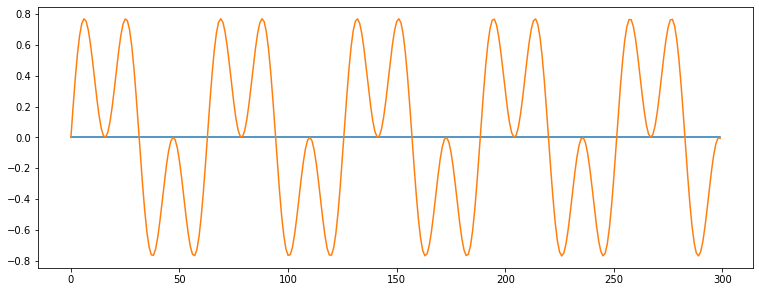

Diff: 0.4987078709567035
Alpha: 0.01


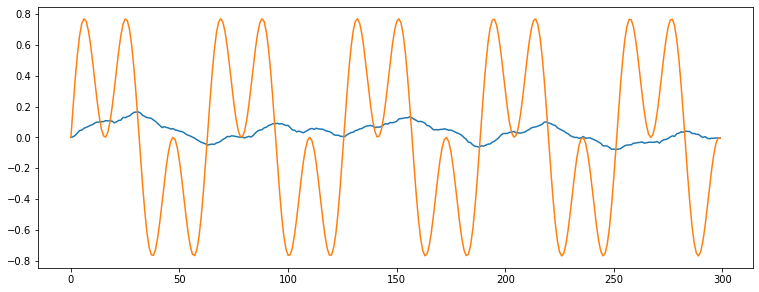

Diff: 0.49869379573306777
Alpha: 0.1


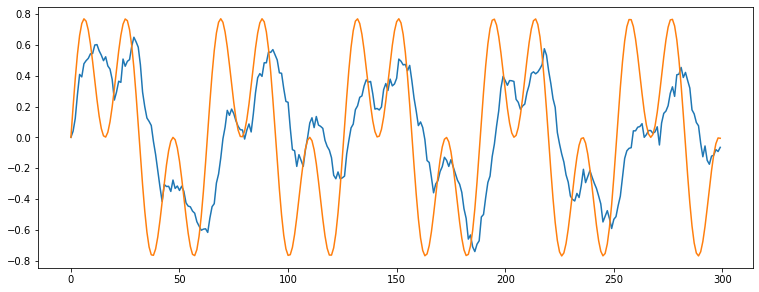

Diff: 0.43201943409984117
Alpha: 0.2


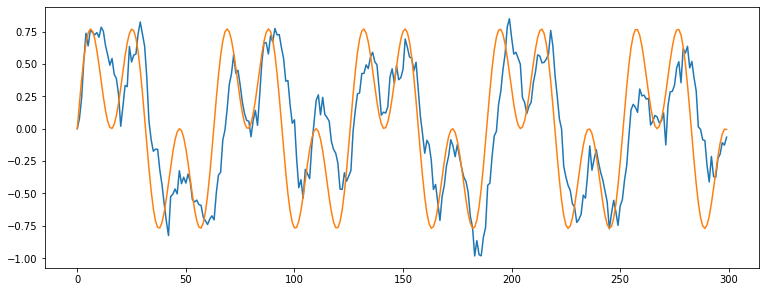

Diff: 0.3545473718802782
Alpha: 0.3


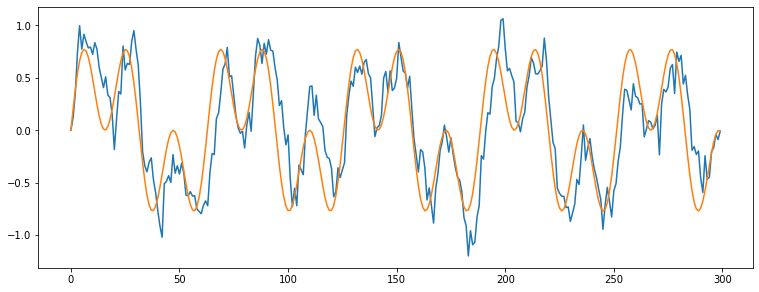

Diff: 0.31340085726017686
Alpha: 0.4


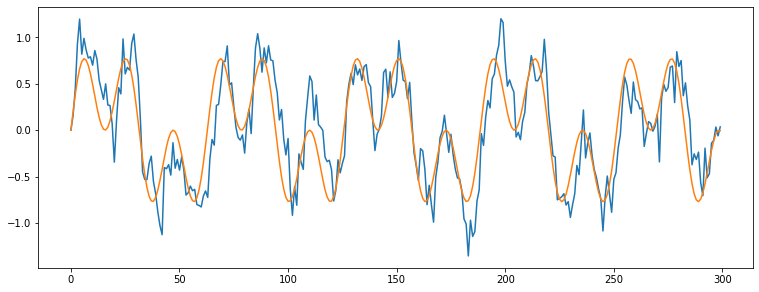

Diff: 0.30262587649259304
Alpha: 0.5


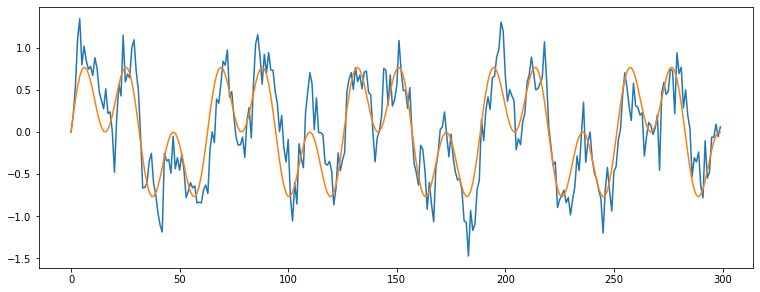

Diff: 0.31338245561995326


In [6]:
for alpha in [0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5]:
  print("Alpha:", alpha)
  filtered = np.zeros(measurements.shape[0])
  for i in range(1, measurements.shape[0]):
    filtered[i] = filtered[i-1] + alpha * (measurements[i] - filtered[i-1])
  plt.plot(filtered)
  plt.plot(data)
  plt.show()
  print("Diff:", np.sqrt(np.mean((filtered - data) ** 2)))

Как видите, при $\alpha = 0.4$ получилось добиться наиболее правдоподобных значений.

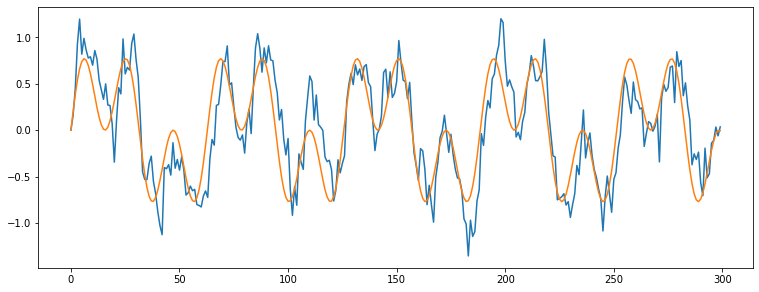

In [7]:
alpha = 0.4
filtered = np.zeros(measurements.shape[0])
for i in range(1, measurements.shape[0]):
  filtered[i] = filtered[i-1] + alpha * (measurements[i] - filtered[i-1])
plt.plot(filtered)
plt.plot(data)
plt.show()

Давайте ещё раз посмотрим на входные данные и увидим значительную разницу.

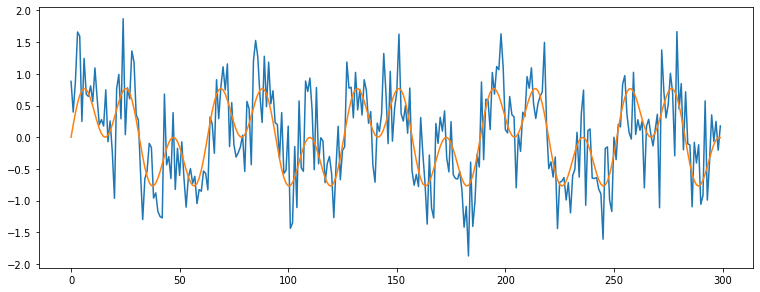

In [8]:
plt.plot(measurements)
plt.plot(data)
plt.show()

Давайте теперь рассмотрим другой фильтр - Simple moving average (SMA). Подробнее можно прочитать тут: https://en.wikipedia.org/wiki/Moving_average

Если кратко, суть достаточно проста: по последовательности входных значений скользит окно фиксированного размера (размер окна - параметр фильтра; например, если размер окна N, то рассматриваются каждые N последовательных значений), для которых вычисляется среднее арифметическое значение - это значение на выходе.

Как можно заметить, если на входе M значений, то при размере окна N на выходе получается M-N+1 значений. Поэтому, чтобы значения на выходе по времени соответствовали середине окна, по которому они были вычислены, дополним значения на входе слева N/2 нулями (для простоты используем целочисленное деление).

Реализуем этот фильтр:

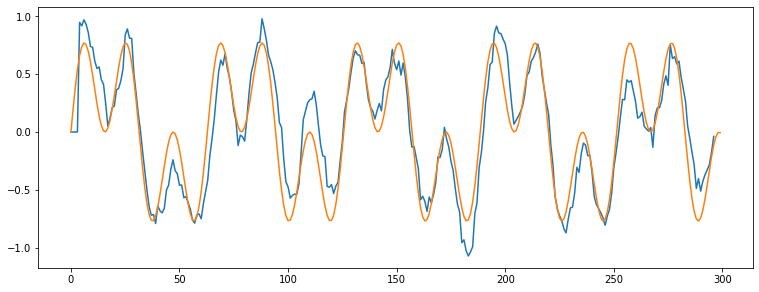

In [9]:
ws = 8
filtered = np.concatenate((np.zeros(ws//2), np.array([np.mean(measurements[i:i+ws]) for i in range(measurements.shape[0]-ws+1)])))
plt.plot(filtered)
plt.plot(data)
plt.show()

В принципе, получилось неплохо. Но следует помнить, что если у Вас будут сильные выбросы значений, среднее арифметическое значение на выходе будет также сильно искажено. Чтобы этого избежать, можете различными способами избавляться от выбросов или вместо арифметического среднего использоваться, например, медиану.

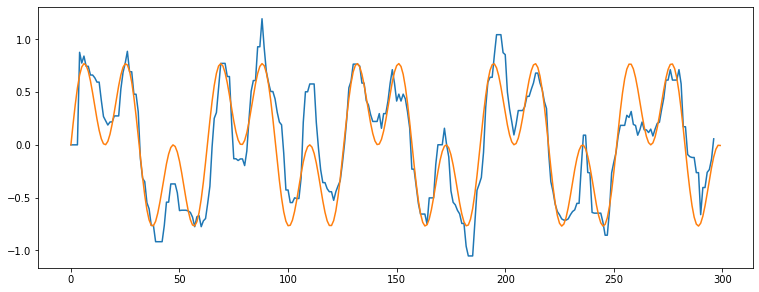

In [10]:
ws = 8
filtered = np.concatenate((np.zeros(ws//2), np.array([np.median(measurements[i:i+ws]) for i in range(measurements.shape[0]-ws+1)])))
plt.plot(filtered)
plt.plot(data)
plt.show()

В принципе, тоже неплохо. Давайте ещё раз посмотрим, что было на входе.

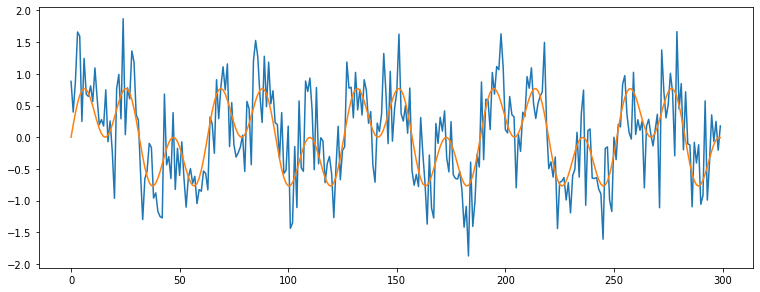

In [11]:
plt.plot(measurements)
plt.plot(data)
plt.show()

Теперь давайте рассмотрим другой случай - низкочастотные шумы. Чтобы сгенерировать низкочастотный шум, используем интерполяцию случайных чисел с нормальным распределением.

Построим график (синий - данные, оранжевый - шум):

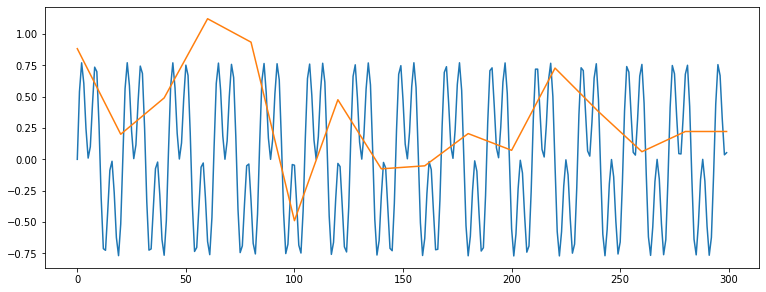

In [12]:
np.random.seed(0)
data = (np.sin(np.arange(300) * 0.3) + np.sin(np.arange(300) * 0.9)) * 0.5
noise = np.interp(np.arange(300), np.arange(15) * 20, np.random.normal(0, 0.5, 15))
plt.plot(data)
plt.plot(noise)
plt.show()

Опять получим измерения как сумму данных с шумом и построим график:

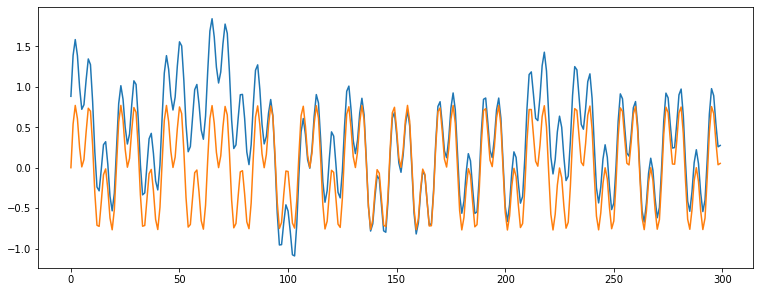

In [13]:
measurements = data + noise
plt.plot(measurements)
plt.plot(data)
plt.show()

Опять начнём с простого - High-pass filter. Подробно можно прочитать тут: https://en.wikipedia.org/wiki/High-pass_filter

Если кратко, вот формула:
$$ y_i = \alpha \times (y_{i−1} + x_i − x_{i−1}), $$
где $x_i$ - входные данные, $y_i$ - выходные данные, $\alpha$ - параметр сглаживания.

Давайте попробуем его применить.

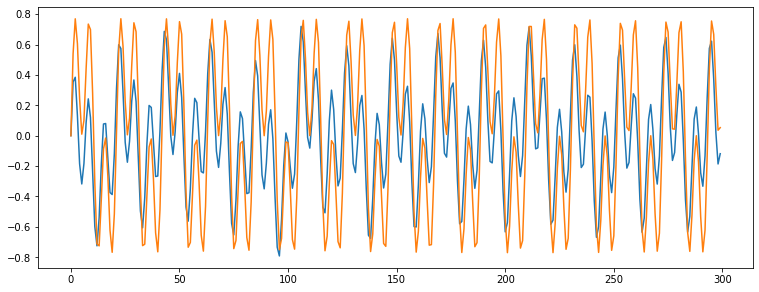

In [14]:
alpha = .7

filtered = np.zeros(measurements.shape[0])
for i in range(1, measurements.shape[0]):
  filtered[i] = alpha * (filtered[i-1] + measurements[i] - measurements[i-1])
plt.plot(filtered)
plt.plot(data)
plt.show()

В принципе, получилось неплохо. Можете попробовать посмотреть, что будети при других значениях $\alpha$.

А помните про простое скользящее среднее? Его также можно использовать, но есть один нюанс: с помощью скользящего окна мы получим значение шума, а после этого вычтем его из измерений:

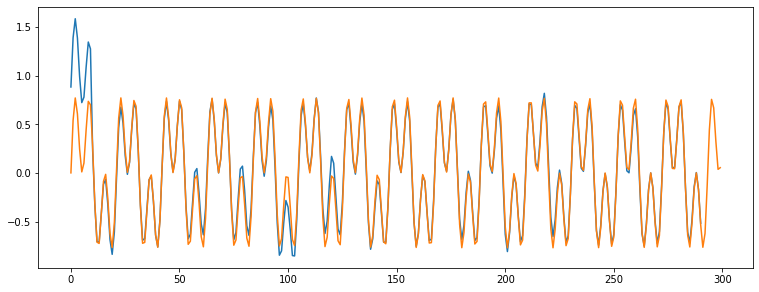

In [15]:
ws = 20
filtered = np.concatenate((np.zeros(ws//2), np.array([np.mean(measurements[i:i+ws]) for i in range(measurements.shape[0]-ws+1)])))
filtered = measurements[:filtered.shape[0]] - filtered
plt.plot(filtered)
plt.plot(data)
plt.show()

Смотрите, какая красота!

Заметьте, что можно применять несколько фильтров последовательно, чтобы добиться нужного результата.

А вот теперь задание: реализовать функцию, на входе которой одномерный массив с измерениями от датчика, а на выходе - отфильтрованное значение. Так как задание очень простое, вариант один. Вот пример:

In [16]:
test_data = np.array([ 6.95700472e-01,  6.18232232e-01,  5.40763991e-01,  4.63295751e-01,
        3.85827511e-01,  3.08359270e-01,  2.30891030e-01,  1.53422789e-01,
        7.59545491e-02, -1.51369129e-03, -7.89819317e-02, -9.03862558e-02,
       -1.01790580e-01, -1.13194904e-01, -1.24599228e-01, -1.36003552e-01,
       -1.47407876e-01, -1.58812201e-01, -1.70216525e-01, -1.81620849e-01,
       -1.93025173e-01, -2.28660371e-01, -2.64295569e-01, -2.99930767e-01,
       -3.35565965e-01, -3.71201163e-01, -4.06836361e-01, -4.42471559e-01,
       -4.78106757e-01, -5.13741955e-01, -5.49377154e-01, -5.62615184e-01,
       -5.75853214e-01, -5.89091244e-01, -6.02329275e-01, -6.15567305e-01,
       -6.28805335e-01, -6.42043365e-01, -6.55281396e-01, -6.68519426e-01,
       -6.81757456e-01, -7.05872034e-01, -7.29986611e-01, -7.54101188e-01,
       -7.78215766e-01, -8.02330343e-01, -8.26444921e-01, -8.50559498e-01,
       -8.74674075e-01, -8.98788653e-01, -9.22903230e-01, -7.95178130e-01,
       -6.67453031e-01, -5.39727931e-01, -4.12002831e-01, -2.84277731e-01,
       -1.56552632e-01, -2.88275319e-02,  9.88975679e-02,  2.26622668e-01,
        3.54347767e-01,  3.23211591e-01,  2.92075414e-01,  2.60939238e-01,
        2.29803061e-01,  1.98666885e-01,  1.67530708e-01,  1.36394532e-01,
        1.05258355e-01,  7.41221786e-02,  4.29860021e-02, -2.31534383e-02,
       -8.92928787e-02, -1.55432319e-01, -2.21571760e-01, -2.87711200e-01,
       -3.53850640e-01, -4.19990081e-01, -4.86129521e-01, -5.52268962e-01,
       -6.18408402e-01, -4.63684235e-01, -3.08960069e-01, -1.54235902e-01,
        4.88264479e-04,  1.55212431e-01,  3.09936598e-01,  4.64660764e-01,
        6.19384931e-01,  7.74109097e-01,  9.28833264e-01,  7.93903201e-01,
        6.58973138e-01,  5.24043075e-01,  3.89113012e-01,  2.54182949e-01,
        1.19252887e-01, -1.56771764e-02, -1.50607239e-01, -2.85537302e-01,
       -4.20467365e-01, -3.39020436e-01, -2.57573508e-01, -1.76126579e-01,
       -9.46796501e-02, -1.32327213e-02,  6.82142074e-02,  1.49661136e-01,
        2.31108065e-01,  3.12554994e-01,  3.94001922e-01,  2.91216352e-01,
        1.88430782e-01,  8.56452120e-02, -1.71403582e-02, -1.19925928e-01,
       -2.22711498e-01, -3.25497069e-01, -4.28282639e-01, -5.31068209e-01,
       -6.33853779e-01, -5.02327081e-01, -3.70800382e-01, -2.39273684e-01,
       -1.07746985e-01,  2.37797132e-02,  1.55306412e-01,  2.86833110e-01,
        4.18359809e-01,  5.49886507e-01,  6.81413206e-01,  6.34588562e-01,
        5.87763919e-01,  5.40939276e-01,  4.94114633e-01,  4.47289989e-01,
        4.00465346e-01,  3.53640703e-01,  3.06816060e-01,  2.59991416e-01,
        2.13166773e-01,  2.07715363e-01,  2.02263952e-01,  1.96812542e-01,
        1.91361131e-01,  1.85909721e-01,  1.80458310e-01,  1.75006900e-01,
        1.69555489e-01,  1.64104079e-01,  1.58652668e-01,  1.62682779e-01,
        1.66712889e-01,  1.70742999e-01,  1.74773110e-01,  1.78803220e-01,
        1.82833331e-01,  1.86863441e-01,  1.90893552e-01,  1.94923662e-01,
        1.98953773e-01,  8.27240758e-02, -3.35056211e-02, -1.49735318e-01,
       -2.65965015e-01, -3.82194712e-01, -4.98424409e-01, -6.14654106e-01,
       -7.30883803e-01, -8.47113500e-01, -9.63343196e-01, -8.15466855e-01,
       -6.67590515e-01, -5.19714174e-01, -3.71837833e-01, -2.23961492e-01,
       -7.60851507e-02,  7.17911902e-02,  2.19667531e-01,  3.67543872e-01,
        5.15420213e-01,  4.67797994e-01,  4.20175774e-01,  3.72553555e-01,
        3.24931336e-01,  2.77309116e-01,  2.29686897e-01,  1.82064678e-01,
        1.34442458e-01,  8.68202392e-02,  3.91980199e-02, -1.77188436e-02,
       -7.46357071e-02, -1.31552571e-01, -1.88469434e-01, -2.45386298e-01,
       -3.02303161e-01, -3.59220025e-01, -4.16136888e-01, -4.73053751e-01,
       -5.29970615e-01, -5.20395224e-01, -5.10819834e-01, -5.01244444e-01,
       -4.91669053e-01, -4.82093663e-01, -4.72518272e-01, -4.62942882e-01,
       -4.53367491e-01, -4.43792101e-01, -4.34216710e-01, -2.91112222e-01,
       -1.48007734e-01, -4.90324554e-03,  1.38201243e-01,  2.81305731e-01,
        4.24410219e-01,  5.67514707e-01,  7.10619195e-01,  8.53723684e-01,
        9.96828172e-01,  9.26215333e-01,  8.55602494e-01,  7.84989656e-01,
        7.14376817e-01,  6.43763978e-01,  5.73151139e-01,  5.02538300e-01,
        4.31925462e-01,  3.61312623e-01,  2.90699784e-01,  2.62721534e-01,
        2.34743284e-01,  2.06765034e-01,  1.78786784e-01,  1.50808534e-01,
        1.22830284e-01,  9.48520335e-02,  6.68737834e-02,  3.88955333e-02,
        1.09172833e-02, -7.72376825e-02, -1.65392648e-01, -2.53547614e-01,
       -3.41702580e-01, -4.29857545e-01, -5.18012511e-01, -6.06167477e-01,
       -6.94322442e-01, -7.82477408e-01, -8.70632374e-01, -7.97761849e-01,
       -7.24891325e-01, -6.52020800e-01, -5.79150275e-01, -5.06279751e-01,
       -4.33409226e-01, -3.60538702e-01, -2.87668177e-01, -2.14797652e-01,
       -1.41927128e-01, -1.15619554e-01, -8.93119797e-02, -6.30044056e-02,
       -3.66968316e-02, -1.03892575e-02,  1.59183165e-02,  4.22258906e-02,
        6.85334646e-02,  9.48410386e-02,  1.21148613e-01,  1.74078801e-01,
        2.27008990e-01,  2.79939179e-01,  3.32869368e-01,  3.85799556e-01,
        4.38729745e-01,  4.91659934e-01,  5.44590122e-01,  5.97520311e-01,
        6.50450500e-01,  5.05735765e-01,  3.61021030e-01,  2.16306295e-01,
        7.15915603e-02, -7.31231746e-02, -2.17837909e-01, -3.62552644e-01,
       -5.07267379e-01, -6.51982114e-01, -7.96696849e-01, -7.96696849e-01,
       -7.96696849e-01, -7.96696849e-01, -7.96696849e-01, -7.96696849e-01,
       -7.96696849e-01, -7.96696849e-01, -7.96696849e-01, -7.96696849e-01])
test_noise = np.array([-6.60260046e-01, -2.17368299e+00, -1.84949120e+00, -1.33929329e+00,
       -9.75999249e-01, -1.53839653e+00, -7.65509369e-01, -5.24856469e-01,
       -1.38586938e+00, -6.03238649e-01, -1.30622827e+00, -1.70572427e+00,
       -7.13283342e-01, -3.51042583e-01, -1.00702604e-01,  1.57183159e-02,
       -8.94698424e-01, -2.88838043e-02, -9.34357291e-01,  4.01826131e-01,
       -1.49086878e+00, -9.66529277e-01, -5.47231478e-01, -4.79126678e-01,
       -2.66482073e-01, -1.03521778e+00, -4.73030795e-01, -1.17374238e-01,
        8.45192794e-02, -7.93894118e-01, -8.56098343e-01, -6.89571625e-01,
        8.67237307e-02, -4.53901520e-01, -5.65866773e-01, -5.56353711e-03,
        9.23859734e-02,  5.19164254e-02,  3.44661453e-01, -4.95970454e-01,
       -1.91411306e-01,  8.36460926e-02,  8.43102254e-02, -1.15527081e-01,
       -7.64363155e-01, -2.68080577e-01,  1.02338802e+00,  7.50134991e-01,
       -2.36212049e-01,  2.12435306e-01,  1.20680602e+00,  3.91647884e-01,
        3.55998436e-01,  9.36331404e-01,  3.52257882e-01,  9.72409525e-01,
        7.02289639e-01,  1.89405584e+00,  1.03117922e+00,  1.50182325e+00,
        3.98952118e-02,  4.52346714e-01,  3.48780867e-01,  6.77275831e-01,
        7.71960099e-01,  2.38458843e-01,  8.01770092e-01,  1.09018208e+00,
        1.67532914e+00,  1.46005837e+00,  1.90136352e+00,  1.90054658e+00,
        1.90223264e+00,  1.54084512e+00,  1.89006622e+00,  2.03663902e+00,
        9.28363849e-01,  2.22871133e+00,  2.12300083e+00,  1.39607180e+00,
        1.41256116e+00,  1.26025616e+00,  2.10917753e+00,  1.94986026e+00,
        2.00143361e+00,  1.68835695e+00,  2.18508318e+00,  1.92559395e+00,
        1.71151431e+00,  2.14566855e+00,  1.74603865e+00,  2.63195469e+00,
        1.62144459e+00,  2.59060434e+00,  3.11883085e+00,  2.69548882e+00,
        2.17377413e+00,  2.21994365e+00,  3.07305687e+00,  2.83887807e+00,
        2.62910235e+00,  2.20773286e+00,  3.30297585e+00,  3.20931213e+00,
        3.43910694e+00,  2.71733874e+00,  3.38852654e+00,  3.18807768e+00,
        3.91394025e+00,  2.81082718e+00,  2.39091929e+00,  2.71542719e+00,
        3.06537730e+00,  2.93077853e+00,  4.30744977e+00,  3.03512045e+00,
        3.52193596e+00,  3.01019760e+00,  3.15574769e+00,  3.37801404e+00,
        2.70698208e+00,  3.63362368e+00,  2.85788178e+00,  2.58837297e+00,
        2.93917733e+00,  2.34686878e+00,  2.81990395e+00,  2.77262079e+00,
        3.09095578e+00,  2.00575239e+00,  1.92327442e+00,  2.40095518e+00,
        1.73301862e+00,  1.33483650e+00,  1.96895237e+00,  2.10099898e+00,
        1.56332081e+00,  9.70795761e-01,  1.37139790e+00,  1.23959057e+00,
       -2.97622763e-01,  8.49650200e-01,  1.24010693e+00,  1.01682003e+00,
        3.13676480e-01, -1.05907177e-01, -4.47331803e-01,  1.31125877e-01,
       -3.18974994e-01, -3.06408341e-01, -8.40392573e-01, -1.72761160e+00,
       -1.61432422e+00, -2.34007672e+00, -1.18426105e+00, -1.57534203e+00,
       -1.53256932e+00, -2.25921148e+00, -2.17590207e+00, -2.81179553e+00,
       -1.65051874e+00, -2.42115997e+00, -1.63934511e+00, -3.77406447e+00,
       -2.68302057e+00, -2.96604966e+00, -3.64696405e+00, -3.55832540e+00,
       -3.56351643e+00, -3.72896755e+00, -3.37900181e+00, -3.43330983e+00,
       -4.32324867e+00, -4.45744434e+00, -4.31113995e+00, -4.01357714e+00,
       -4.11535234e+00, -5.24297433e+00, -3.94070571e+00, -5.69556652e+00,
       -4.65994252e+00, -5.08664845e+00, -4.73723158e+00, -4.73462059e+00,
       -5.29970582e+00, -4.89906491e+00, -4.87366085e+00, -4.94613323e+00,
       -5.79689692e+00, -5.22299588e+00, -4.77107909e+00, -4.49973702e+00,
       -5.06795336e+00, -5.22063381e+00, -5.17557962e+00, -5.39426503e+00,
       -4.59205694e+00, -3.90528504e+00, -4.74361047e+00, -5.72851618e+00,
       -5.02287339e+00, -5.31441690e+00, -4.63502065e+00, -4.76864548e+00,
       -5.63593007e+00, -4.30905829e+00, -5.45479242e+00, -4.69088261e+00,
       -5.10120999e+00, -4.99899362e+00, -5.15264124e+00, -4.28911290e+00,
       -4.85321832e+00, -5.53557158e+00, -5.10222907e+00, -4.78657370e+00,
       -4.81062122e+00, -4.22760876e+00, -5.05569635e+00, -5.12841460e+00,
       -5.15999278e+00, -4.42182925e+00, -4.35137166e+00, -4.65868325e+00,
       -4.34942447e+00, -4.62193328e+00, -4.92726793e+00, -4.23998671e+00,
       -5.19773052e+00, -4.80989939e+00, -4.36847899e+00, -4.16557951e+00,
       -4.48630417e+00, -4.40167922e+00, -4.85165208e+00, -4.21018886e+00,
       -5.05805172e+00, -4.45086355e+00, -3.61522337e+00, -4.70915554e+00,
       -3.99997521e+00, -4.96687757e+00, -4.93092664e+00, -5.00167375e+00,
       -4.41312438e+00, -4.53930997e+00, -4.25685582e+00, -5.17894733e+00,
       -4.93858469e+00, -4.47629157e+00, -4.25664986e+00, -5.86442285e+00,
       -4.91912755e+00, -4.52229543e+00, -4.99615345e+00, -5.01510127e+00,
       -5.51098644e+00, -4.70588890e+00, -4.49492068e+00, -5.10767041e+00,
       -4.20653615e+00, -5.04141345e+00, -5.20714882e+00, -5.25605019e+00,
       -4.80891092e+00, -4.77893530e+00, -5.06136440e+00, -4.40394421e+00,
       -3.82194752e+00, -4.51254884e+00, -4.29105195e+00, -3.54296837e+00,
       -5.14510167e+00, -4.16283417e+00, -4.64850082e+00, -3.85578878e+00,
       -3.58230747e+00, -4.24743276e+00, -4.14726541e+00, -4.62710279e+00,
       -4.80605263e+00, -4.78385330e+00, -4.38448513e+00, -4.44610977e+00,
       -4.39404584e+00, -4.88036933e+00, -4.74723215e+00, -5.06621875e+00,
       -4.60557002e+00, -4.38886998e+00, -4.49610014e+00, -5.89698969e+00,
       -4.51719090e+00, -4.30505658e+00, -4.63892590e+00, -4.91996945e+00,
       -4.87394967e+00, -5.26603640e+00, -4.86316909e+00, -4.77083564e+00])
test_measurements = test_data + test_noise

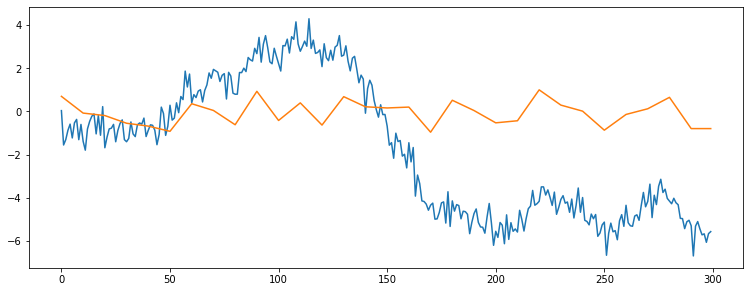

In [17]:
plt.plot(test_measurements)
plt.plot(test_data)
plt.show()

Немного вспомогательного кода для автоматической проверки

In [18]:
import urllib.request
from json import dumps, loads

server = "https://eztester.agridnev.com"
task_id = 4

def get_variant():
  response = urllib.request.urlopen(server + "/task/" + str(task_id) + "/variant?secret=" + secret)
  variant = int(response.read().decode("utf-8"))
  return variant

def auto_test(func):
  response = urllib.request.urlopen(server + "/task/" + str(task_id) + "?secret=" + secret)
  token = response.read().decode("utf-8")
  results = []
  for case in range(20):
    response = urllib.request.urlopen(server + "/data/measurements?case=" + str(case) + "&token=" + token)
    measurements = np.array(loads(response.read().decode("utf-8")), dtype=float)
    filtered = func(measurements)
    plt.plot(filtered)
    plt.plot(measurements)
    plt.show()
    results.append(filtered.tolist())
  req = urllib.request.Request(server + "/solution?token=" + token)
  req.add_header("Content-Type", "application/json")
  data = dumps(results).encode('utf-8')
  req.add_header('Content-Length', len(data))
  response = urllib.request.urlopen(req, data)
  print("Passed! First time passed:", response.read().decode("utf-8"))

def print_info():
  response = urllib.request.urlopen(server + "/user?secret=" + secret)
  info = loads(response.read().decode("utf-8"))
  print("Full name:", info["name"])
  print("Group:", info["group"])
  print("Tasks: (id --- name --- solution)")
  for id in info["tasks"]:
    task = info["tasks"][id]
    print(id, "---", task["name"], "---", task["solution"])

Как и раньше, сюда вставьте свой секрет

In [19]:
secret = "faaf64fa1f4b461fa2d627ffaec3ce4a"

А тут реализуйте свой фильтр

In [22]:
def your_filter(measurements):
  # hpf
  ws = 30
  filtered = np.concatenate((np.zeros(ws//2), np.array([np.mean(measurements[i:i+ws]) for i in range(measurements.shape[0]-ws+1)])))
  filtered = measurements[:filtered.shape[0]] - filtered

  # low_pass_alpha = .1
  # filtered1 = np.zeros(measurements.shape[0])
  # for i in range(1, measurements.shape[0]):
  #   filtered1[i] = filtered1[i-1] + low_pass_alpha * (measurements[i] - filtered1[i-1])
  # filtered1 = measurements
  # high_pass_alpha = .6
  # filtered2 = np.zeros(filtered1.shape[0])
  # for i in range(1, filtered1.shape[0]):
  #   filtered2[i] = high_pass_alpha * (filtered2[i-1] + filtered1[i] - filtered1[i-1])

  # lpf
  ws = 10
  filtered3 = np.concatenate((np.zeros(ws//2), np.array([np.mean(filtered[i:i+ws]) for i in range(filtered.shape[0]-ws+1)])))
  return filtered3

Реализовали? Проверьте, как он работает на примере:

Measurements:


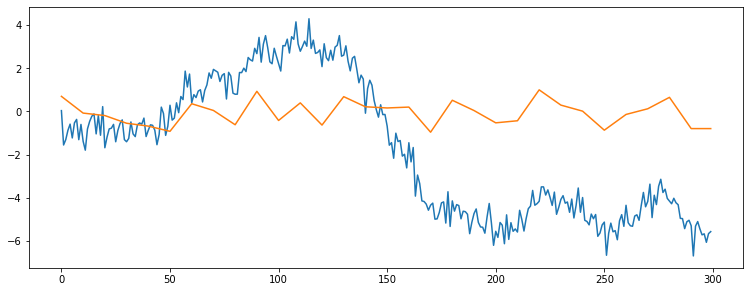

Filtered:


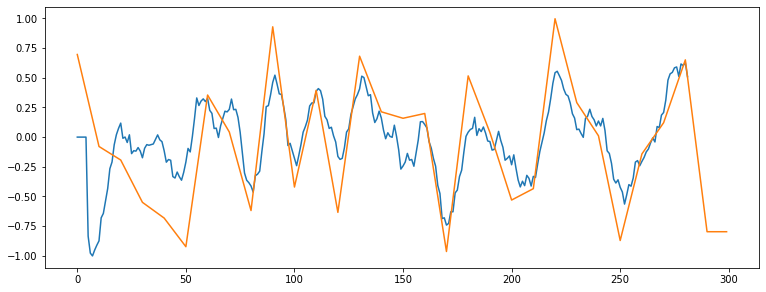

Diff: 0.2505898547041409


In [23]:
print("Measurements:")
plt.plot(test_measurements)
plt.plot(test_data)
plt.show()
print("Filtered:")
test_filtered = your_filter(test_measurements)
plt.plot(test_filtered)
plt.plot(test_data)
plt.show()
print("Diff:", np.sqrt(np.mean((test_filtered[50:250] - test_data[50:250]) ** 2)))

У меня без проблем получилось добиться менее 0.42, чего достаточно для прохождения теста

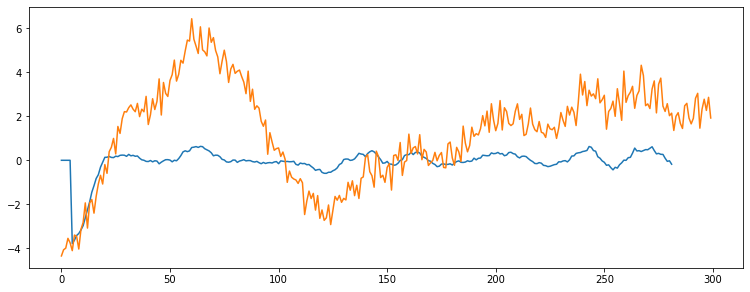

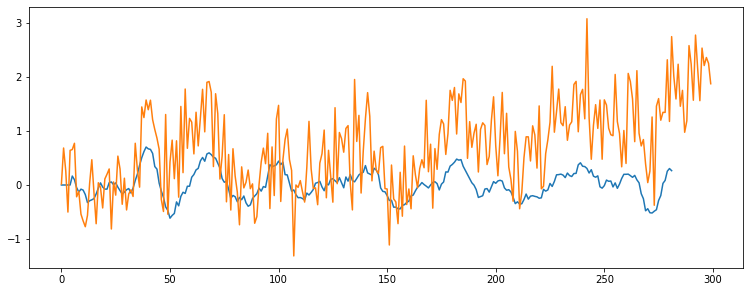

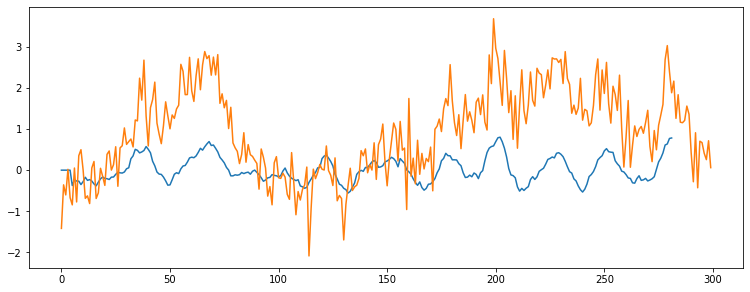

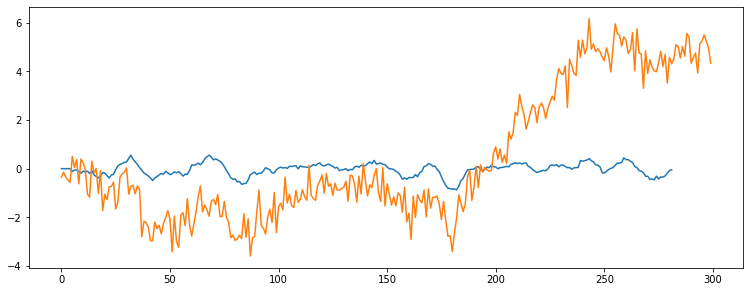

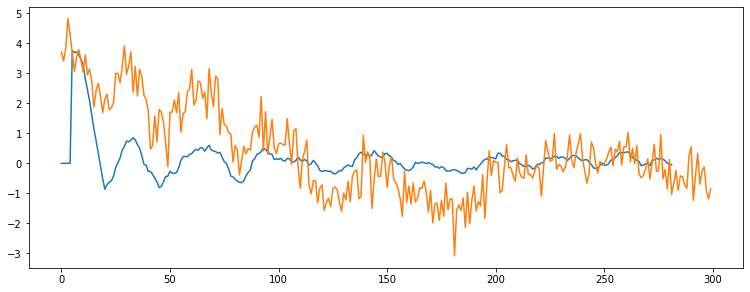

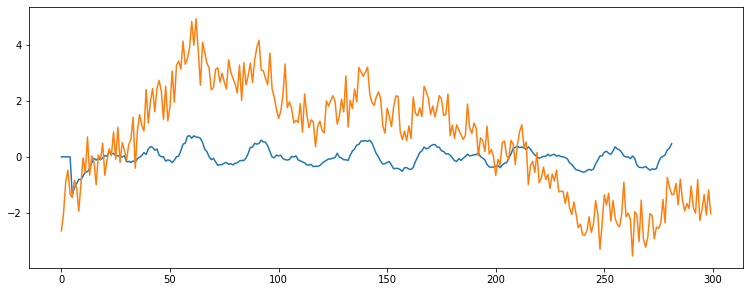

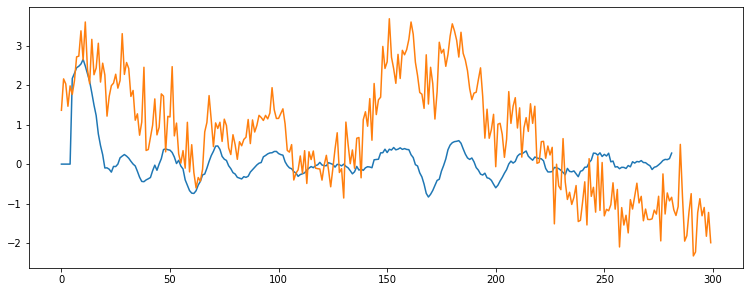

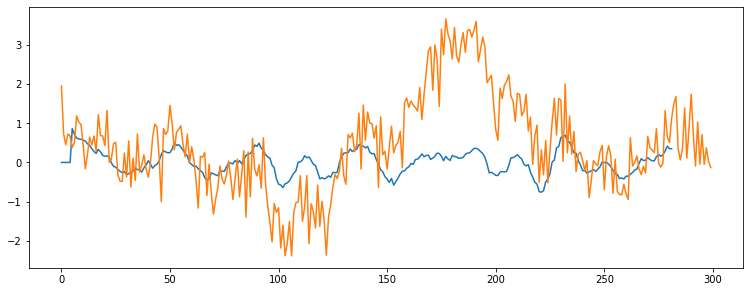

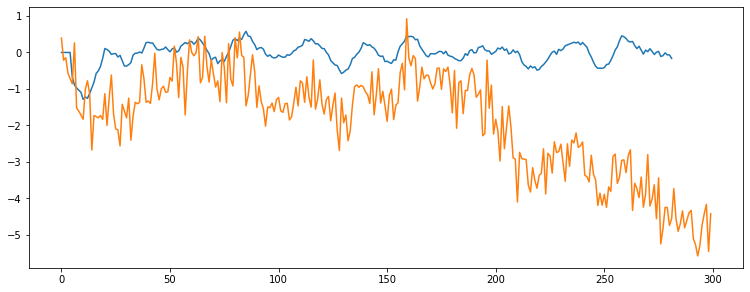

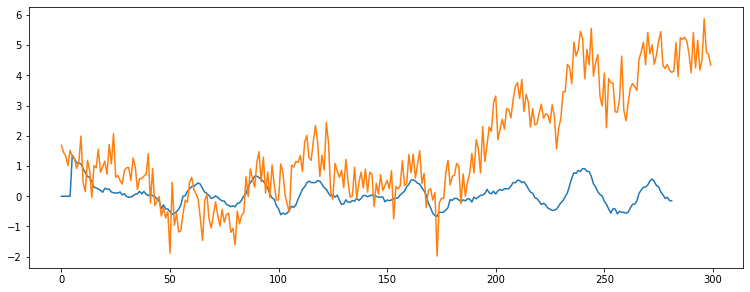

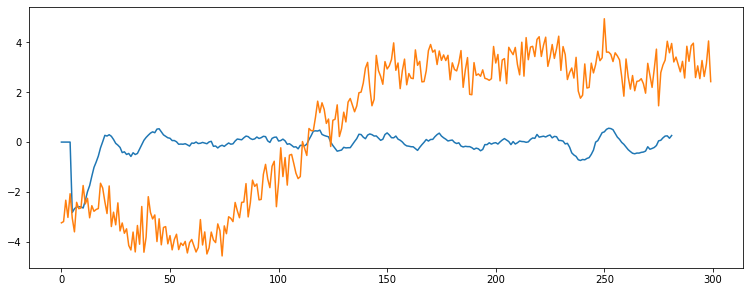

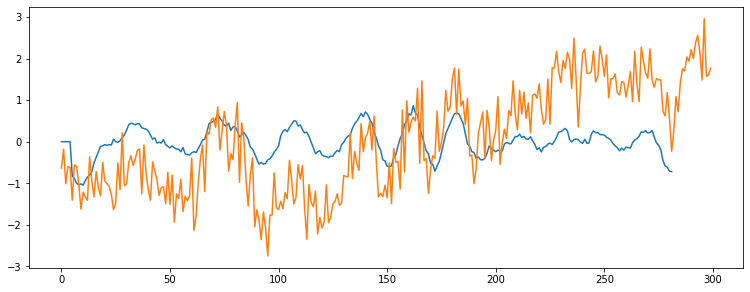

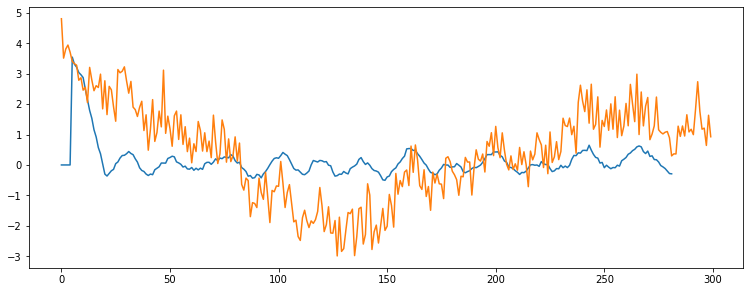

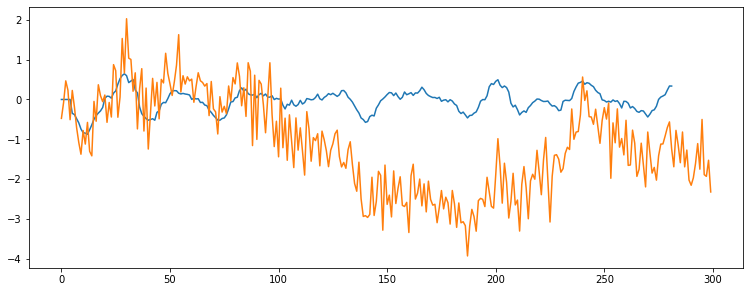

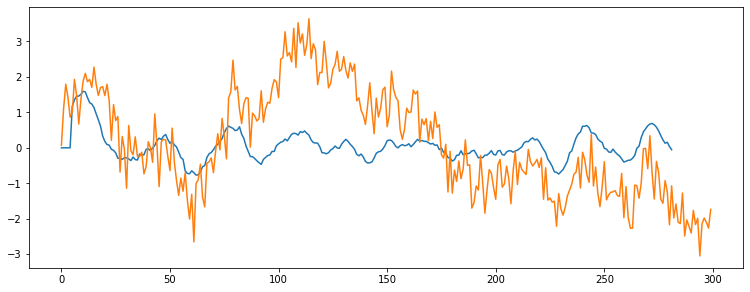

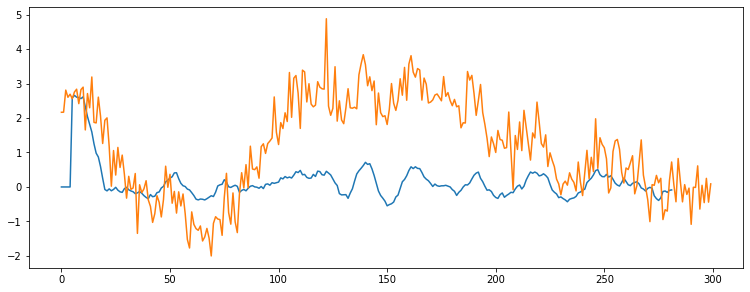

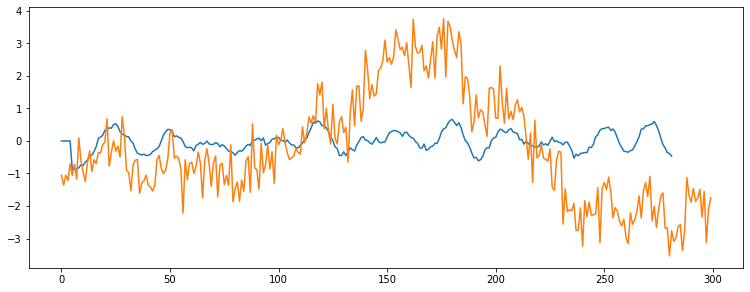

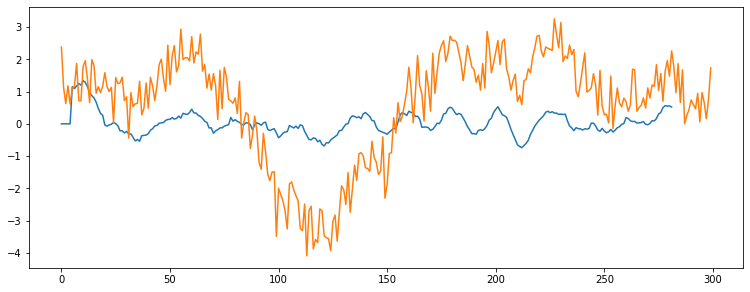

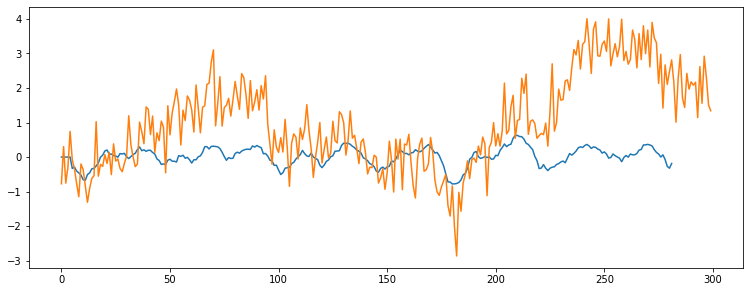

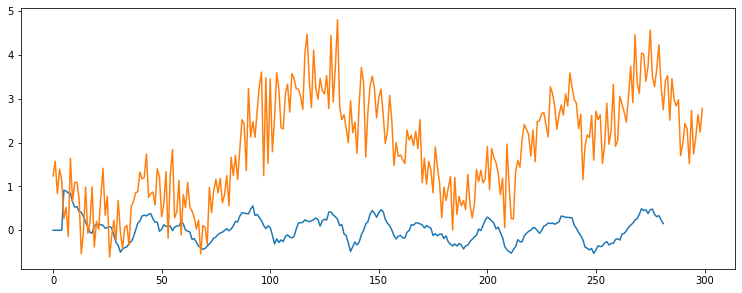

Passed! First time passed: "2021-09-24T11:29:11.231459"


In [ ]:
auto_test(your_filter)

В этот раз ограничение по времени - 20 секунд, чего должно быть достаточно. Сразу предупреждаю, на входе случайные числа и частично Вашу судьбу решает рандом. Он может сгенерировать что-то очень срашное, что даже правильно реализованный фильтр не справится, но при проверке система достаточно щедрая. Если Вам не повезёт, можете попробовать ещё несколько раз (так как вероятность получить плохие данные на входе достаточно мала). Если у Вас многократно не получается пройти проверку, ещё раз пересмотрите свой фильтр и ещё раз проверьте его на примере выше.

А теперь можете проверить свои успехи:

In [ ]:
print_info()

Full name: Базин Антон Владимирович
Group: Б18-503
Tasks: (id --- name --- solution)
1 --- 0a - Hello world --- 2021-09-03T13:30:08.095889
2 --- 0b - Hello NumPy --- 2021-09-09T10:47:28.096867
3 --- 0c - Hello OpenCV --- 2021-09-09T11:06:22.783564
4 --- 1a - Basic Filters --- 2021-09-24T11:29:11.231459
7 --- 2a - PID --- 2021-09-27T19:22:25.281888
8 --- 2b - PID + BB --- 2021-09-27T19:25:56.709593
10 --- 3a - FFT --- 2021-09-30T11:28:37.456427
11 --- 3b - FFT + Audio --- 2021-10-17T09:40:10.226226
13 --- 4a - Haar --- 2021-12-09T11:20:16.577064
16 --- 5a - ANN --- 2021-12-16T09:57:56.179112
